# **Functions Section**

These are all the functions of the SDMVLM, in this section the user can go through the functions and change as needed.

To use the program scroll down to the following section.

In [ ]:
#Python library imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
#Functions to mesh and find the panel values
def mesh_quad(NW,NE,SW,SE,ns,nc,airfoil,winglet_check,winglet_wrt_NE,winglet_wrt_SE,wing_symmetry):
    camber  = camber_equation(airfoil,nc)
    le = split_lines(NW,NE,ns)
    te = split_lines(SW,SE,ns)
    le,te,ns = include_winglet(winglet_check,winglet_wrt_NE,winglet_wrt_SE,le,te,ns)
    le,te,ns = include_wall_BV(wing_is_open,le,te,ns)
    le = mirror_line(le,wing_symmetry)
    te = mirror_line(te,wing_symmetry)
    ns,nc = mirror_ns_nc(wing_symmetry,ns,nc)
    listoflines = make_point_lines(le,te,ns,nc)
    camberedlist = add_camber(listoflines,camber)
    panels_generated = get_panel_points(camberedlist,ns,nc)
    return panels_generated,ns,nc,le,te

def find_panel_values(panels_generated):
    cps = find_cp_list(panels_generated)
    bvs = find_bv_list(panels_generated)
    normals = find_normal_list(panels_generated)
    return cps,bvs,normals

In [ ]:
#Meshing functions
#Used to split two points into a line having a finite number of points
def split_lines(point1,point2,n):
    points = []
    p1 = np.array(point1)
    p2 = np.array(point2)
    inc = (p2-p1)/n
    for i in range(n+1):
        pi = i*inc + point1
        pi = pi.tolist()
        points.append(pi)
    return points

#Used to making points inbetween two lines
def make_point_lines(line1,line2,n,m):
    l1 = np.array(line1)
    l2 = np.array(line2)
    line = []
    for i in range(n+1):
        segmented_point = split_lines(l1[i],l2[i],m)
        line.append(segmented_point)
        #print(segmented_point)
    return line

#Making the panels from the list of lines
def get_panel_points(list_of_lines,n,m):
    panel_list = []
    for i in range(m):
        for j in range(n):
            panel = [
                list_of_lines[j][i],
                list_of_lines[j+1][i],
                list_of_lines[j+1][i+1],
                list_of_lines[j][i+1]
            ]
            #print(panel)
            panel_list.append(panel)
    return panel_list

#Find the middle point between two points
def find_mid_point(point1,point2):
    p1 = np.array(point1)
    p2 = np.array(point2)
    midpoint = 0.5*(p1+p2)
    return midpoint

#Finding the control point for each panel and storing them in the form of a list
def find_cp_list(panel_list):
    cp_list=[]
    '''
    ------>y
    |
    | x
    Ap1  Bp2
    Dp4  Cp3
    '''
    for panel in panel_list:
        p1 = panel[0]
        p2 = panel[1]
        p3 = panel[2]
        p4 = panel[3]
        mid_AB = find_mid_point(p1,p2)
        mid_CD = find_mid_point(p3,p4)
        centre_of_panel = find_mid_point(mid_AB,mid_CD)
        cp = find_mid_point(centre_of_panel,mid_CD)
        cp_listed = cp.tolist()
        cp_list.append(cp_listed)
    return cp_list

#Finding the bound vortices of each panel and storing them in the form of a list
def find_bv_list(panel_list):
    bv_list = []
    '''
    ------>y
    |
    | x
    Ap1  Bp2
    Dp4  Cp3
    '''
    for panel in panel_list:
        p1 = panel[0]
        p2 = panel[1]
        p3 = panel[2]
        p4 = panel[3]
        mid_AD = find_mid_point(p1,p4)
        mid_BC = find_mid_point(p2,p3)
        bv = [find_mid_point(p1,mid_AD).tolist(),find_mid_point(p2,mid_BC).tolist()]
        bv_list.append(bv)
    return bv_list

#Finding the normal to each panel and storing it in a list
def find_normal_list(panel_list):
    normal_list = []
    '''
    ------>y
    |
    | x
    Ap1  Bp2
    Dp4  Cp3
    '''
    for panel in panel_list:
        p1 = np.array(panel[0])
        p2 = np.array(panel[1])
        p3 = np.array(panel[2])
        p4 = np.array(panel[3])
        AC = p3-p1
        CB = p2-p4
        normal = np.cross(AC,CB)
        normal_normalised = normal/np.linalg.norm(normal)
        normal_listed = normal_normalised.tolist()
        normal_list.append(normal_listed)
    return normal_list

#Finding the area of each panel
def find_area(panel):
    p1 = np.array(panel[0])
    p2 = np.array(panel[1])
    p3 = np.array(panel[2])
    p4 = np.array(panel[3])
    p = [p1,p2,p3,p4]
    path = []
    for i in range(len(p) - 1):
        step = p[i + 1] - p[i]
        path.append(step)
        area = 0
    for i in range(len(path) - 1):
        s = np.cross(path[i], path[i + 1])
        s = np.linalg.norm(s)
        area += 0.5 * s
    return area
'''
def find_total_area(panels):
    total_area = 0
    for panel in panels:
        panel_area = find_area(panel)
        total_area = total_area + panel_area
    return total_area
'''
#Finding the total planform area based on the geometry conditions described in the user input
def find_total_area(panels,open_wing,winglet_check,wing_symmetry):
    total_area = 0
    area_wall_BC = 0
    area_winglet = 0
    if open_wing == False:
        area_wall_segment = find_area(panels[0])
        area_wall_BC = area_wall_segment*nc
    if winglet_check == True:
        area_winglet_segment = find_area(panels[ns-1])
        area_winglet = area_winglet_segment*nc
        #print(panels[ns-1])
    if wing_symmetry == True:
        area_winglet = area_winglet*2
    for panel in panels:
        panel_area = find_area(panel)
        total_area = total_area + panel_area
    total_area_summed = total_area - area_wall_BC - area_winglet
    #print("Total area", total_area_summed)
    return total_area_summed


In [ ]:
#Functions calculating symmetry and camber

#Mirroring the geometry in the y-axis
def mirror_line(line,symmetry):
    if symmetry == True:
        old_line = line
        new_line =[]
        for point in line:
            mirrored_point = [point[0],-point[1],point[2]]
            new_line.append(mirrored_point)
        new_line = new_line[::-1]
        new_line.pop()
        for point in old_line:
            new_line.append(point)

    else:

        new_line = line

    return new_line

#Doubling the number of spanwise divisions due to symmetry
def mirror_ns_nc(symmetry,ns,nc):
    if symmetry == True:
        ns_new = 2*ns
        nc_new = nc
    else:

        ns_new = ns
        nc_new = nc
    return ns_new,nc_new

#Developing the camber equation based on the user airfoil input
def camber_equation(airfoil, nc):
    #x represents position wrt chord i.e x/c
    #Final returned result must be multiplied by chord length
    if airfoil[0] == 0 & airfoil[1] == 0 :
        camber_x = 0
    else:
        x_list = []
        x = 0
        for i in range(nc+1):
            inc = 1/nc
            x = i*inc
            x_list.append(x)
        m = airfoil[0]/100
        p = airfoil[1]/10
        camber_x = []
        for x in x_list:
            if x <= p:
                zc = (m/(p**2))*(2*p*x-(x**2))
                c_x = [x,0,zc]
                camber_x.append(c_x)
            else:
                zc = (m/((1-p)**2))*((1-2*p)+2*p*x-(x**2))
                c_x = [x,0,zc]
                camber_x.append(c_x)
    return camber_x

#Adding camber to the list of lines
def add_camber(listoflines,camber):
    camberedlist = []
    if camber == 0:
        camberedlist = listoflines

    else:
        for line in listoflines:
            for i in range(len(line)):
                chord_length = line[-1][0] - line [0][0]
                line[i][2] = line[i][2]+(chord_length*camber[i][2])
            camberedlist.append(line)
    return camberedlist

#Including a winglet based on user input
def include_winglet(check,winglet_NE,winglet_SE,le,te,ns):
    if check == False:
        return le,te,ns
    else:
        le_span = np.array(le[-1])
        winglet_NE = np.array(winglet_NE)
        NE_cord = le_span+winglet_NE
        NE_cord = NE_cord.tolist()
        te_span = np.array(te[-1])
        winglet_SE = np.array(winglet_SE)
        SE_cord = te_span+winglet_SE
        SE_cord = SE_cord.tolist()
        le.append(NE_cord)
        te.append(SE_cord)
        ns = ns+1
    return le,te,ns

#Adding the wall boundary condition
def include_wall_BV(check,le,te,ns):
    if check == True:
        return le,te,ns
    else:
        le_0 = np.array(le[0])
        wall_NE = np.array([0,0,10] )
        NE_cord = (le_0+wall_NE).tolist()
        te_0 = np.array(te[0])
        wall_SE = np.array([0,0,10])
        SE_cord = (te_0+wall_SE).tolist()
        le.insert(0,NE_cord)
        te.insert(0,SE_cord)
        ns = ns+1
    return le,te,ns

In [ ]:
#Fuctions finding the influences of vortices

#Function to determine if the selected control point lies in the vortex core, this is used to switch off the velocity induced by the finite vortex if needed
def is_in_vortex_core(tab):
    for t in tab:
        if np.linalg.norm(t) <  1e-9:
            return True

#Finding the velocity induced by a finite vortex as developed by Mason
def v_induced_by_finite_vortex_segment(cp,bv1,bv2,gamma=1):
    cp = np.array(cp)
    bv1 = np.array(bv1)
    bv2 = np.array(bv2)
    r0 = bv2-bv1
    r1 = cp-bv1
    r2 = cp-bv2

    if is_in_vortex_core([r1, r2, np.cross(r1,r2)]):
        return [0,0,0]
    else:
        #To find phi
        r1xr2 = np.cross(r1,r2)
        magnituder1xr2 = np.linalg.norm(r1xr2)
        phi = ((r1xr2[0])/(magnituder1xr2**2),(r1xr2[1])/(magnituder1xr2**2),(r1xr2[2])/(magnituder1xr2**2))
        #To find omega
        magr1 = np.linalg.norm(r1)
        magr2 = np.linalg.norm(r2)
        unitr1 = (r1[0]/magr1,r1[1]/magr1,r1[2]/magr1)
        unitr2 = (r2[0]/magr2,r2[1]/magr2,r2[2]/magr2)
        term1_num = np.dot(r0,r1)
        term1 = term1_num/magr1
        term2_num = np.dot(r0,r2)
        term2 = term2_num/magr2
        omega = term1 - term2
        #To find vab
        vab = np.dot((gamma/(4*math.pi))*omega,phi)
    return vab

#Finding the velocity induced by a semi-infinite vortex as defined by Mason
def v_induced_by_infinite_vortex(cp,bv1,gamma=1):
    cp = np.array(cp)
    bv1 = np.array(bv1)
    r1 = cp-bv1
    magr1 = np.linalg.norm(r1)
    coefficient = ((0.25*gamma)/math.pi)*(1 + (r1[0])/(magr1))*(1/(((r1[2])**2)+(((-1)*r1[1])**2)))
    vainf = (0,coefficient*r1[2],coefficient*(-1)*(r1[1]))
    return vainf

#Finding the total velocity induced by a horseshoe vortex on a point
def v_induced_by_horseshoe_vortex(cp,bv1,bv2,gamma=1):
    v_ab = v_induced_by_finite_vortex_segment(cp,bv1,bv2,gamma=gamma)
    v_ainf = v_induced_by_infinite_vortex(cp,bv1,gamma=1*gamma)
    v_binf = v_induced_by_infinite_vortex(cp,bv2,gamma=-1*gamma)

    v_induced = np.sum([v_ainf,v_binf,v_ab],axis=0)
    return v_induced

In [ ]:
#Functions solving the governing VLM equation
def get_aerodynamic_influence(normal,v_induced):
    aero_influence = np.dot(v_induced,normal)
    return aero_influence

#Calculating and constructing the LHS matrix
def find_LHS_matrices(panel_list,cp_list,bv_list,normal_list):
    gamma_coefficient_matrix = []
    v_induced_coefficient_matrix = []
    for i in range(len(panel_list)):
        cp_i = cp_list[i]
        n_i = normal_list[i]
        influence_on_panel = []
        induced_coefficient = []
        for j in range(len(panel_list)):
            bv_j = bv_list[j]
            v_induced_coefficient_j = v_induced_by_horseshoe_vortex(cp_i,bv_j[0],bv_j[1],gamma=1)
            influence_j_i = get_aerodynamic_influence(n_i,v_induced_coefficient_j)
            induced_coefficient.append(v_induced_coefficient_j)
            influence_on_panel.append(influence_j_i)
        gamma_coefficient_matrix.append(influence_on_panel)
        v_induced_coefficient_matrix.append(induced_coefficient)
    return  gamma_coefficient_matrix, v_induced_coefficient_matrix

#Developing the RHS matrix
def get_RHS_matrix(panel_list,normal_list,AoA,side_slip,v_inf_2,v_inf):
    RHS_matrix = []
    for i in range(len(panel_list)):
        n_i = normal_list[i]
        v_local = [(-1)*v_inf*np.cos(AoA)*np.cos(side_slip),v_inf*np.sin(side_slip),(-1)*v_inf*np.sin(AoA)*np.cos(side_slip)]
        RHS = np.dot(v_local,n_i)
        RHS_matrix.append(RHS)
    RHS_matrix = np.vstack(RHS_matrix)
    return RHS_matrix

#Solving the matrix equation
def solve_matrix_eqn(AIM,RHS_matrix):
    AIM_inv = np.linalg.inv(AIM)
    gamma_list = np.dot(AIM_inv,RHS_matrix)
    return gamma_list

In [ ]:
#Function solving for the forces on the submerged body
def calculate_force(v_inf_list,gamma_magnitudes,panels,cp_list,bv_list,rho,v_inf,AoA,side_slip,ns):
    v_ind_coeff = np.full((len(panels), len(panels), 3), 0., dtype=float)
    v_induced = []
    for i in range(0, len(panels)):
        bv_i = bvs[i]
        cp_i = (find_mid_point(bv_i[0],bv_i[1]))
        v_i = []
        for j in range(0, len(panels)):
            bv_j = bvs[j]
            # velocity induced at i-th control point relative to the midpoint of the j-th vortex, by the j-th vortex
            v_ind_j_i = v_induced_by_horseshoe_vortex(cp_i,bv_j[0],bv_j[1],gamma = gamma_magnitudes[j][0])
            v_i.append(v_ind_j_i)
        v_i_summed = np.sum(v_i,axis = 0).tolist()
        v_induced.append(v_i_summed)
    forces = []
    for i in range(0, len(panels)):
        bv_i = bvs[i]
        l = np.array(bv_i[1])-np.array(bv_i[0])
        gamma_l = l*gamma_magnitudes[i][0]
        v_local = [v_inf*np.cos(AoA)*np.cos(side_slip),(-1)*v_inf*np.sin(side_slip),v_inf*np.sin(AoA)*np.cos(side_slip)]
        vel = np.array(v_local) + np.array(v_induced[i])
        force_i = (rho*np.cross(vel,gamma_l)).tolist()
        rotation_i = [
                [np.cos(side_slip)*np.cos(AoA),-np.sin(side_slip),np.cos(side_slip)*np.sin(AoA)],
                [np.sin(side_slip)*np.cos(AoA),np.cos(side_slip),np.sin(side_slip)*np.cos(AoA)],
                [-np.sin(AoA),0,np.cos(AoA)]
            ]
        force_i_rotated = np.dot(rotation_i,force_i)
        forces.append(force_i_rotated)

    if wing_is_open == False:
        forces.pop(0)

        return forces
    else:

        return forces


# **User Input Section**

The following section allows the user to input the wing and free stream parameters

**Use this block to input the coordinates of the wing and specify if the wing is symmetrical about the root chord**

In [ ]:
#user input - wing configuration
#dihedral is assumed to vary linearly with span inputted with the z coordinate of the points
NW = [0,0,0]
NE = [0.2105,4.57/2,0.0044]
SE = [(0.2105+0.1684),4.57/2,-0.0044]
SW = [0.5895,0,0]
"""
----------->y
|
|
x
NW
            NE
            SE
SW
"""
#Note that when wing is symmetrical, the number of spanwise divisions will double
wing_symmetry = True

**Use this block to specify the chordwise and spanwise divisions**

In [ ]:
#ns is spanwise divisions
#nc is chordwise divisions
ns=12
nc=6

**Use this block to denote the airfoil in the NACA 4 digit convention**

In [ ]:
#Airfoil definition using NACA 4 digit convention
airfoil = [4,4,12]

**Use this to define the winglet should the wing have one**

In [ ]:
#Winglet inclusion if no winglet set winglet_check to False, if winglet set to True and input the y and z position wrt the NE-SE line
winglet_check = False
winglet_wrt_NE= [0,0,0.1]
winglet_wrt_SE=[0,0,0.1]

**Use this to model the disruptive effect of a boundary, note this does not solve for the force on the boundary**

In [ ]:
#If the wing is not symmetrical, set the boundary condition should you want a closed or open wing, if the wing is symmetrical this must always be True
wing_is_open = True
if wing_symmetry == True:
    wing_is_open = True

**Freestream definition block**

In [ ]:
#freestream velocity magnitude
v_inf = 40.85

#angle of attack relative to lifting surface
AoA_initial = 0
#del_AoA defines the angle of attack steps
del_AoA = 0.5
AoA_final = 5

#side slip angle of the wing
side_slip = np.deg2rad(2)

#freestream density
rho = 1.225

This block calculates the range of angle of attack based on user input and calculates the dynamic pressure of the freestream

In [ ]:
AoA_list = [AoA_initial]
AoA_i = AoA_initial
AoA_list_rad = [np.deg2rad(AoA_initial)]
while AoA_i < AoA_final:
    AoA_i = AoA_i + del_AoA
    AoA_list.append(AoA_i)
    AoA_list_rad.append(np.deg2rad(AoA_i))

#dynamic pressure
q = 0.5*rho*v_inf**2

# **Output Section**

The following section shows the outputs of the program. From this point onwards, the user is not required to input anymore definitions.

This block develops the panelled geometry

In [ ]:
#Meshing the domain, results give panels, ns, nc, leading edge and, trailing edge
panels_generated,ns,nc,le,te = mesh_quad(NW,NE,SW,SE,ns,nc,airfoil,winglet_check,winglet_wrt_NE,winglet_wrt_SE,wing_symmetry)
#Calculates the CPs, BVs and, normals for each panel. Each are lists equal in length to the number of panels i.e. ns*nc
cps,bvs,normals = find_panel_values(panels_generated)

This block provides a 3D visualisation of the wing generated

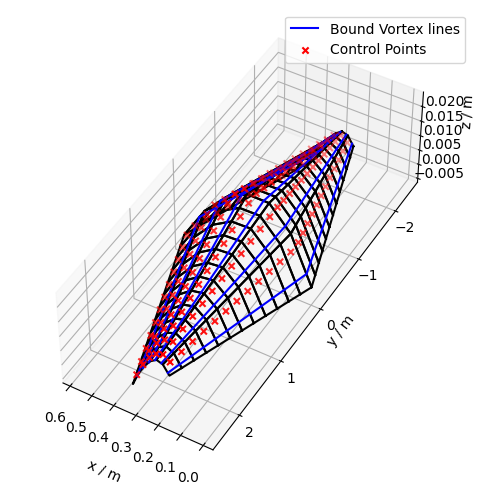

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x / m')
ax.set_ylabel('y / m')
ax.set_zlabel('z / m')

for i in range(len(panels_generated)):
    panel = panels_generated[i]
    x_coords, y_coords, z_coords = zip(*panel)
    ax.plot(x_coords + (x_coords[0],), y_coords + (y_coords[0],), z_coords + (z_coords[0],), color='black')

for i in range(len(bvs)):
    plt.plot([bvs[i][0][0], bvs[i][1][0]], [bvs[i][0][1], bvs[i][1][1]],[bvs[i][0][2], bvs[i][1][2]], color='blue', linestyle='-', label='Bound Vortex lines' if i == 0 else '')
cp_x,cp_y,cp_z = zip(*cps)
ax.scatter(cp_x, cp_y,cp_z, color='red', label='Control Points', marker='x')

ax.view_init(elev=45, azim=120)
ax.legend(loc = 'best')
ax.set_box_aspect([4, 10, 3])

This block solves the VLM formulation using the functions defined in the first section of this notebook. The output of the program is given below this block

In [ ]:
Cl_list_AoA = []
Cd_list_AoA = []
Lift_list_AoA = []
Drag_list_AoA = []
lift_dist_AoA = []

for AoA in AoA_list_rad:
    #force rotation matrix to align bodyforces with freestream
    rotation = [
                [np.cos(side_slip)*np.cos(AoA),-np.sin(side_slip),np.cos(side_slip)*np.sin(AoA)],
                [np.sin(side_slip)*np.cos(AoA),np.cos(side_slip),np.sin(side_slip)*np.cos(AoA)],
                [-np.sin(AoA),0,np.cos(AoA)]
            ]
    #freestream parametrised
    v_inf_2 = [v_inf*np.cos(AoA)*np.cos(side_slip),(-1)*v_inf*np.sin(side_slip),v_inf*np.sin(AoA)*np.cos(side_slip)]

    #Solves the matrix equation, returns the Aero influence matrix (Cmn*n), v_ind_coeff (Cmn), RHS_matrix (v_inf*n) and, gamma magnitude
    LHS_matrix_2,v_induced_coefficient_2 = find_LHS_matrices(panels_generated,cps,bvs,normals)
    RHS_matrix_2 = get_RHS_matrix(panels_generated,normals,AoA,side_slip,v_inf_2,v_inf)
    gamma_list_2 = solve_matrix_eqn(LHS_matrix_2,RHS_matrix_2)
    #print("This is gamma_list",gamma_list_2)
    #Calculation the local lift and drag as according to Katz and Plotkin for an unrolled wake

    force_list = calculate_force(v_inf_2,gamma_list_2,panels_generated,cps,bvs,rho,v_inf,AoA,side_slip,ns)

    #Finding the total lift and drag through a summation
    total_force = np.vstack(np.sum(force_list, axis=0))

    #Find the planform area
    planform_area = find_total_area(panels_generated,wing_is_open,winglet_check,wing_symmetry)

    #Finding the lift and drag distributions
    drags,sideforces,lifts = zip(*force_list)
    if wing_is_open == False:
      ns=ns-1
    lift_reshaped = np.reshape(lifts,(nc,ns))
    drag_reshaped = np.reshape(drags,(nc,ns))
    sideforce_reshaped = np.reshape(sideforces,(nc,ns))

    #Finding the 2D flow lift and drag values
    D_lift = []
    D_drag = []
    D_area = []
    #print(lift_reshaped)
    for i in range(len(lift_reshaped)):
      span_divs = len(lift_reshaped[i])
      middle_div = round(span_divs/2)
      D_lift.append(lift_reshaped[i][middle_div])
      D_drag.append(drag_reshaped[i][middle_div])
      panel_no = panels_generated[((ns*i)+middle_div)]
      area_local = find_area(panel_no)
      D_area.append(area_local)
    D_lift_total = np.sum(D_lift,axis=0)
    D_area_total = np.sum(D_area,axis=0)
    Cl2d = D_lift_total/(q*D_area_total)
    lift_distribution = np.sum(lift_reshaped,axis=0)

    #Calculating 3D lift and drag coefficients, note that this drag is only due to 3D effects and includes no viscous or form drag
    lift = total_force[2]
    Cl = lift/(q*planform_area)
    drag = total_force[0]
    Cd = drag/(q*planform_area)
    sideforce = total_force[1]
    print('Angle of attack', math.degrees(AoA))
    print('This is lift and Cl', lift,Cl)
    print('This is induced drag and Cd', drag,Cd)
    print('This is sideforce', sideforce)
    Cl_list_AoA.append(Cl.tolist())
    Cd_list_AoA.append(Cd.tolist())
    Lift_list_AoA.append(lift)
    Drag_list_AoA.append(drag)
    lift_dist_AoA.append(lift_distribution)

Angle of attack 0.0
This is lift and Cl [691.79316624] [0.38909235]
This is induced drag and Cd [7.04739965] [0.00396374]
This is sideforce [24.36820788]
Angle of attack 0.5
This is lift and Cl [772.97982141] [0.434755]
This is induced drag and Cd [8.75808393] [0.0049259]
This is sideforce [27.02481718]
Angle of attack 1.0
This is lift and Cl [854.0737974] [0.48036552]
This is induced drag and Cd [10.65714427] [0.00599401]
This is sideforce [29.63157802]
Angle of attack 1.5000000000000002
This is lift and Cl [935.06397858] [0.52591766]
This is induced drag and Cd [12.74348666] [0.00716745]
This is sideforce [32.187115]
Angle of attack 2.0
This is lift and Cl [1015.9392838] [0.57140519]
This is induced drag and Cd [15.01587391] [0.00844553]
This is sideforce [34.69009017]
Angle of attack 2.5
This is lift and Cl [1096.68867058] [0.6168219]
This is induced drag and Cd [17.47292653] [0.00982748]
This is sideforce [37.13920394]
Angle of attack 3.0000000000000004
This is lift and Cl [1177.30

The blocks below give the lift and drag polars for the defined analysis

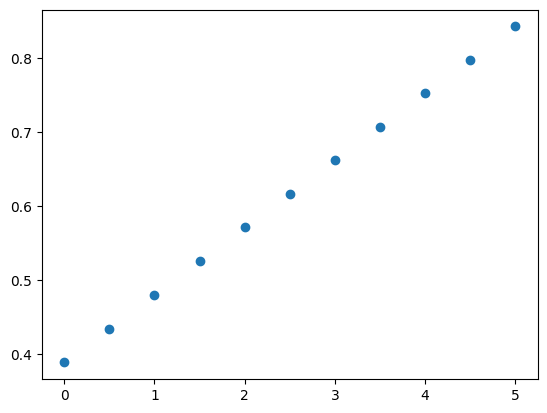

In [ ]:
plt.scatter(AoA_list,Cl_list_AoA)

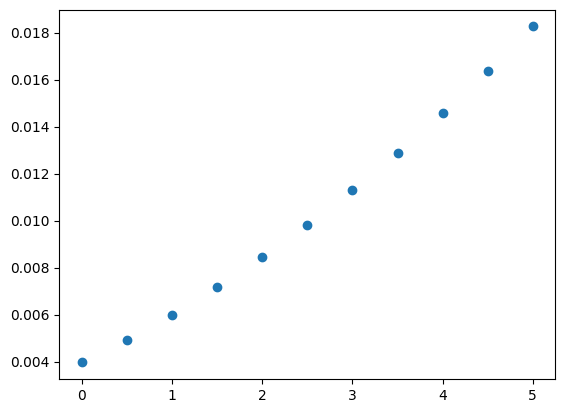

In [ ]:
plt.scatter(AoA_list,Cd_list_AoA)